In [1]:
import geopandas as gpd
import contextily as ctx
import shapely
import pandas as pd
import sys
import re
from wilcoxon import sheets
import seaborn as sns

In [417]:
malls = sheets.getGeo("Malls Alternative")
malls["coords"] = malls[["Longitude","Latitude"]].values.tolist()
malls["coords"] = malls.coords.apply(shapely.geometry.Point)
malls = gpd.GeoDataFrame(malls, geometry="coords")

In [421]:
bus = sheets.getGeo("Bus")
bus["coords"] = bus[["Longitude","Latitude"]].values.tolist()
bus["coords"] = bus.coords.apply(shapely.geometry.Point)
bus = gpd.GeoDataFrame(bus, geometry="coords")

In [3]:
elevation = gpd.read_file("../Geospatial/GEOSPATIAL/national-map-line/national-map-line-geojson.geojson")
elevation["Location"] = elevation.Description.str.extract("<td>(.*?)</td>")

elevation = elevation[elevation.Location.str.contains("^\d+$")]
L = []
for geometry in elevation.geometry.tolist():
    try:
        L.append(shapely.geometry.Polygon([(float(i[0]), float(i[1])) for i in re.findall("(\d+\.\d+)\s(\d+\.\d+)", str(geometry))]))
    except:
        L.append("")
elevation["polygon"] = L
elevation = elevation[elevation.polygon != ""]

multipolygons = []
for location in elevation.Location.unique():
    multipolygons.append({"alt": int(location), "geometry":shapely.geometry.MultiPolygon(elevation[elevation.Location == location].polygon.tolist())})
    
multipolygons = gpd.GeoDataFrame(multipolygons)

In [400]:
def alt(coords):
    closestDistances = {x: 1000 for x in multipolygons.alt.unique()}
    maxalt = 0

    for polygon, alt in elevation[["polygon","Location"]].values.tolist():
        point = coords
        distance = polygon.exterior.distance(point)
        closestDistances[int(alt)] = min(closestDistances[int(alt)], distance)
        if point.within(polygon) and maxalt < int(alt):
            maxalt = int(alt)

    return ((maxalt + 20) * closestDistances[maxalt] + (maxalt) * closestDistances[maxalt + 20]) / (closestDistances[maxalt] + closestDistances[maxalt + 20])

In [422]:
malls["Alt"] = malls.coords.apply(alt)
bus["Alt"] = bus.coords.apply(alt)

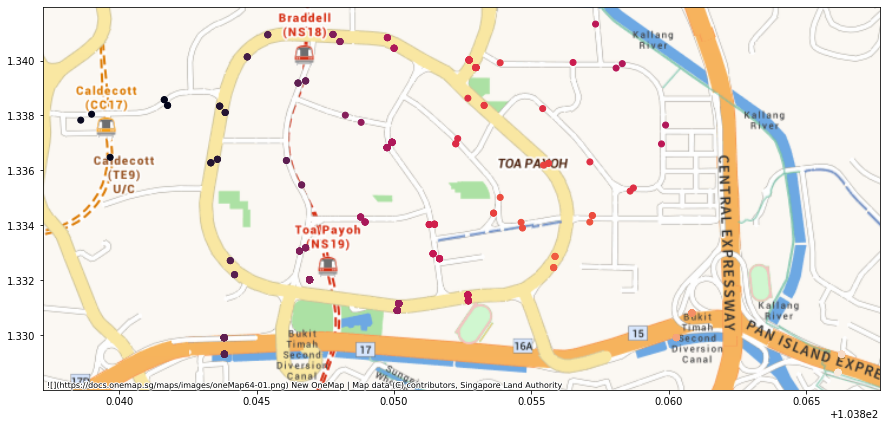

In [447]:
# ax = elevation[elevation.Location.str.contains("^\d{2}$")].plot(figsize=(16,16),facecolor="green", alpha=0.4)
ax = bus[bus.RoadName.fillna("").str.contains("Toa Payoh")].plot(figsize=(15,15),column="Alt", cmap=sns.color_palette("rocket_r", as_cmap=True))
ctx.add_basemap(ax,crs="EPSG:4326",source=ctx.providers.OneMapSG.Default,zoom=15)

<AxesSubplot:>

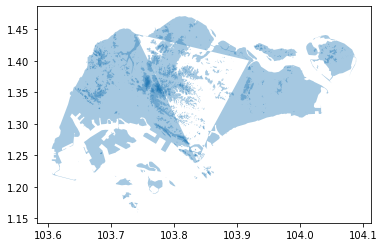

In [6]:
multipolygons.plot(alpha=0.4)

<AxesSubplot:>

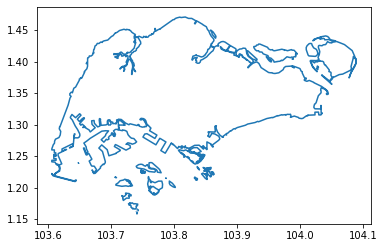

In [17]:
elevation[elevation.Location=='0'].plot()

In [22]:
elevation["geometry"] = elevation.polygon
elevation["Area"] = elevation.area

<ipython-input-22-95b4f7f61030>:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  elevation["Area"] = elevation.area


In [38]:
elevation = gpd.read_file("Documents/Geospatial/GEOSPATIAL/national-map-line/national-map-line-geojson.geojson")
elevation["Location"] = elevation.Description.str.extract("<td>(.*?)</td>")

elevation = elevation[elevation.Location.str.contains("^\d+$")]

In [45]:
elevation[elevation.Location=='0'].geometry.apply()

1322    LINESTRING Z (103.73823 1.44296 0.00000, 103.7...
1382    LINESTRING Z (103.73819 1.44291 0.00000, 103.7...
1383    LINESTRING Z (103.73805 1.44301 0.00000, 103.7...
1384    LINESTRING Z (103.73805 1.44301 0.00000, 103.7...
1385    LINESTRING Z (103.73805 1.44301 0.00000, 103.7...
                              ...                        
1530    LINESTRING Z (103.83699 1.23965 0.00000, 103.8...
1531    LINESTRING Z (103.64899 1.23980 0.00000, 103.6...
1532    LINESTRING Z (103.77643 1.22962 0.00000, 103.7...
1533    LINESTRING Z (103.82914 1.24077 0.00000, 103.8...
1534    LINESTRING Z (103.83705 1.24162 0.00000, 103.8...
Name: geometry, Length: 131, dtype: geometry